# Terzo notebook per il training della rete

#### Si eseguirà la classificazione di 3 classi: "Normale", "Crack", "Spalling"

## 1. Definizione imports

In [ ]:
# Roba generica
import numpy as np
from pathlib import Path
import copy

# Gestione dataframe
import pandas as pd

# Per grafici e gestione delle immagini
import cv2 as cv
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn

# Matrice di confusione
from sklearn.metrics import confusion_matrix

# Barre che mostrano il progresso
from fastprogress.fastprogress import master_bar, progress_bar

In [ ]:
# Se uso colab (e dunque dovrò collegarmi a drive)
_COLAB_IN_USE = True
# Se devo aggiornare le librerie (lasciare a True solo la prima esecuzione)
_FIRST_INIT = False
# Se devo scaricare il dataset (lasciare a True solo la prima esecuzione)
_DOWNLOAD_DATASET = False

In [ ]:
# Se uso il drive lo monto
if _COLAB_IN_USE:
  from google.colab import drive
  import sys

  drive.mount("/content/drive/")

  base = Path('/content/drive/My Drive/Tesi Magistrale Informatica/')
  sys.path.append(str(base))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Per colab, aggiornamento delle librerie

In [ ]:
# Da eseguire una singola volta per essere sicuri che le librerie siano presenti aggiornate
if _COLAB_IN_USE and _FIRST_INIT:
  !pip uninstall albumentations
  !pip install albumentations
  !pip install efficientnet_pytorch

In [ ]:
# Modello della rete e funzioni
import JDModel
# Modello personalizzato della nostra rete neurale
from JDModel import ConcreteModel
# Funzioni utili per l'uso della rete
import JDUtils

#### Scarico il dataset nella working directory

In [ ]:
if _COLAB_IN_USE and _DOWNLOAD_DATASET:
  # DA ESEGUIRE SOLO UNA VOLTA, POI IL DATASET SARà GIà NELLA WORKING DIRECTORY
  # Percorso del zip del dataset
  zip_path = base/'Collab/Dataset.zip'
  # Copio dataset nella cartella di work
  !cp "{zip_path}" .
  # Unzippo e rimuovo le immagini che hanno problemi, e lo zip del dataset x liberare spazio
  !unzip -q Dataset.zip
  !rm 'Dataset/Spalling/accept186007.jpg'
  !rm 'Dataset/Spalling/accept186008.jpg'
  !rm 'Dataset/Spalling/accept186009.jpg'
  !rm 'Dataset.zip'

## 2. Definizioni Variabili

### Definizione Variabili Generiche

In [ ]:
#----- VARIABILI PER I PERCORSI DEL DATASET -----
# Path per la classe NORMAL
DS_PATH_NORMAL = Path('./Dataset/Normal/')

# Path per la classe CRACKS
DS_PATH_CRACKS = Path('./Dataset/Crack/')

# Path per la classe SPALLING
DS_PATH_SPALLING = Path('./Dataset/Spalling/')

# Path per il percorso in cui andrò a salvare i parametri del modello
# Le estensioni standard sono .pt e .pth
MODEL_SAVE_PATH= Path('/content/drive/My Drive/Tesi Magistrale Informatica/Test_Model_Params.pt')
#------------------------------------------------

#----- VARIABILI PER IL DATAFRAME -----
# Dimensione del training set: valori accettabili da 0 a 1 (in genere si prende l'80/85%)
training_set_size = 0.88
validation_set_size = 0.11
test_set_size = 0.01
# LA SOMMA DI QUESTI 3 DEVE DARE 1

# Variabili che indicano il nome delle colonne del dataset
c_filepath = "filepath"
c_label = "label"
#--------------------------------------

#----- VARIABILI PER IL DATALOADER -----
# Valori di default che eseguono il caricamento in modalità non multi-threaded
# NON MODIFICARE QUESTI VALORI, decommentare le righe sotto e cambiare il valore la.
DL_TRAINING_N_WORKERS = 0
DL_VALIDATION_N_WORKERS = 0

# In caso di errori di pipeline broken, REIMPOSTARLI ENTRAMBI A 0 (O COMMENTARE QUESTE DUE RIGHE)
DL_TRAINING_N_WORKERS = 4
DL_VALIDATION_N_WORKERS = 3
#---------------------------------------

# RICALCOLARE LE STATS DEL NOSTRO DATASET
# Se vogliamo ricalcolarle impostiamo a True
RECALCULATE_DATASET_STATS = True
# Decidere se usare le nostre stats o quelle di imagenet
# Se Falso usiamo le nostre
# Se True usiamo quelle di imagenet
USE_IMAGENET_STATS = False

# PRINT VALORE VARIABILI
print("----- Paths -----")
print("Path Dataset Normal: " + str(DS_PATH_NORMAL))
print("Path Dataset Cracks: " + str(DS_PATH_CRACKS))
print("Path Dataset Spalling: " + str(DS_PATH_SPALLING))
print("Path Model Params: " + str(MODEL_SAVE_PATH))
print("\n----- DataLoader -----")
print("Training # Workers: " + str(DL_TRAINING_N_WORKERS))
print("Validation # Workers: " + str(DL_VALIDATION_N_WORKERS))
print("\n----- Dataset Size -----")
print("Training set Dimension: " + str(training_set_size * 100) + "%")
print("Validation set Dimension: " + str(validation_set_size * 100) + "%")
print("Test set Dimension: " + str(test_set_size * 100) + "%")
print("\n----- Dataset Stats -----")
print("Recalculate Dataset Stats: " + str(RECALCULATE_DATASET_STATS))
print("Use Imagenet Stats: " + str(USE_IMAGENET_STATS))

----- Paths -----
Path Dataset Normal: Dataset/Normal
Path Dataset Cracks: Dataset/Crack
Path Model Params: /content/drive/My Drive/Tesi Magistrale Informatica/Test_Model_Params.pt

----- DataLoader -----
Training # Workers: 4
Validation # Workers: 3

----- Dataset Size -----
Training set Dimension: 88.0%
Validation set Dimension: 11.0%
Test set Dimension: 1.0%

----- Dataset Stats -----
Recalculate Dataset Stats: True
Use Imagenet Stats: False


### Definizione Variabili della Rete

In [ ]:
# BATCH SIZE, SE SI HA PIù RAM, SI PUò AUMENTARE PER VELOCIZZARE, ALTRIMENTI SI PUò RIDURRE SE SI HA POCA RAM
# Default: 64
batch_size = 128
BS = batch_size

# EPOCHE DI TRAINING (!!> 0) in genere si tiene 5-10-15, ecc ecc...
training_epoques = 10
TE = training_epoques

# LEARNING RATE
learning_rate = 0.01
LR = learning_rate

# WEIGHT DECAY
weight_decay = 0.01
WD = weight_decay

# Flag for feature extracting.
# When False, we finetune the whole model
# When True we block the backbone and update only the new layers.
feature_extract = True

# Nome della rete EfficientNet da utilizzare
network_model_name = JDUtils.getModelName()
# NUMERO DI CLASSI DA CLASSIFICARE (NORMALE, CREPA, FERRO CHE ESCE)
OC = JDUtils.getModelOutputClasses()

######################################################################################################
######################################################################################################
######################################################################################################
# LOSS FUNCTION
# https://pytorch.org/docs/stable/nn.html#loss-functions
loss_fn = nn.BCEWithLogitsLoss()
# MSELoss()
# MultiLabelSoftMarginLoss()
# BCEWithLogitsLoss()
######################################################################################################
######################################################################################################
######################################################################################################

# PRINT VALORE VARIABILI RETE
print("----- Network Training Params -----")
print("Batch size: " + str(BS))
print("Learning Rate: " + str(LR))
print("Weight Decay: " + str(WD))
print("Number of Classes: " + str(OC))
print("Selected Loss Function: " + str(loss_fn))

print("\n----- Finetuning -----")
if feature_extract:
    print("Finetune activated on the new classifier")
else:
    print("Finetune not activated. Training from scratch the whole Network")

----- Network Training Params -----
Batch size: 128
Learning Rate: 0.01
Weight Decay: 0.01
Number of Classes: 3
Selected Loss Function: BCEWithLogitsLoss()

----- Finetuning -----
Finetune activated on the new classifier


## 3. Preparazione Data

### Caricamento del Dataset

In [ ]:
# Inizializzo il random
rseed = JDUtils.init_random()

train_data_normal = [(o, [1, 0, 0]) for o in DS_PATH_NORMAL.iterdir()]
train_data_cracks = [(o, [0, 1, 0]) for o in DS_PATH_CRACKS.iterdir()]
train_data_spalling = [(o, [0, 0, 1]) for o in DS_PATH_SPALLING.iterdir()]
train_data = []
train_data.extend(train_data_normal)
train_data.extend(train_data_cracks)
train_data.extend(train_data_spalling)
# Poichè il dataset di spalling ha circa la metà degli elementi degli altri due dataset
# Lo carico una seconda volta in modo da avere una distribuzione circa uniforme delle classi
train_data.extend(train_data_spalling)
# Creo il dataframe contenente i dati [index, [cd_filepath, cd_label]]
dataset_columns = JDUtils.ConcreteDatasetColumns #[cd_filepath, cd_label]
train_data = pd.DataFrame(train_data, columns = dataset_columns)

# Stampo dimensione dataset
print("Elements Normals: " + str(len(train_data_normal)))
print("Elements Cracks: " + str(len(train_data_cracks)))
print("Elements Spalling: " + str(2*len(train_data_spalling)))
print("Total Elements: " + str(len(train_data)))

Elements Normals: 20000
Elements Cracks: 20000
Elements Spalling: 21518
Total Elements: 61518


### Calcolo Mean ed STD del Dataset

In [ ]:
# Ricalcolare le stats del datasets
# VALORI PRE CALCOLATI DI MEAN E STD DEL NOSTRO DATASET
mean = np.array([0.61536639, 0.64865836, 0.67007833])
std = np.array([0.15830689, 0.15804278, 0.15883725])

# SE SI VOGLIONO RICALCOLARE
if RECALCULATE_DATASET_STATS:
  print("Calcolo Dataset Mean...")
  total_count = 0
  # MEAN
  R_channel = 0
  G_channel = 0
  B_channel = 0
  for row in train_data.iterrows():
    # row => [index, [c_filepath, c_label]]
    img = cv.imread(str(row[1][dataset_columns[0]]))
    R_channel = R_channel + np.sum(img[:, :, 0])
    G_channel = G_channel + np.sum(img[:, :, 1])
    B_channel = B_channel + np.sum(img[:, :, 2])
    total_count = total_count + (img.shape[0] * img.shape[1])

  R_mean = R_channel / total_count
  G_mean = G_channel / total_count
  B_mean = B_channel / total_count

  print("Calcolo Dataset STD...")
  # STD
  R_channel = 0
  G_channel = 0
  B_channel = 0
  for row in train_data.iterrows():
    # row => [index, [c_filepath, c_label]]
    img = cv.imread(str(row[1][dataset_columns[0]]))
    R_channel = R_channel + np.sum((img[:, :, 0] - R_mean) ** 2)
    G_channel = G_channel + np.sum((img[:, :, 1] - G_mean) ** 2)
    B_channel = B_channel + np.sum((img[:, :, 2] - B_mean) ** 2)

  #import math
  #R_std = math.sqrt(R_channel / total_count)
  #G_std = math.sqrt(G_channel / total_count)
  #B_std = math.sqrt(B_channel / total_count)
  R_std = (R_channel / total_count) ** 0.5
  G_std = (G_channel / total_count) ** 0.5
  B_std = (B_channel / total_count) ** 0.5

  # VALORI FINALI NORMALIZZATI IN BASE AL RANGE MASSIMO
  mean = np.array([R_mean, G_mean, B_mean]) / 255
  std = np.array([R_std, G_std, B_std]) / 255
  print("Calcolo Dataset Stats Completato.")

print("Dataset Mean:", mean)
print("Dataset STD: ", std)

Calcolo Dataset Mean...
Calcolo Dataset STD...
Calcolo Dataset Stats Completato.
Dataset Mean: [0.61536639 0.64865836 0.67007833]
Dataset STD:  [0.15830689 0.15804278 0.15883725]


### Generazione Training, Validation e Test set

In [ ]:
train_df, val_df, test_df = np.split(train_data.sample(frac=1, random_state=rseed),
                                 [
                                     int(training_set_size * len(train_data)), # Split TRAINING / (VALIDATION + TEST)
                                     int((training_set_size + validation_set_size) * len(train_data)) # Split VALIDATION / TEST
                                 ]
                                )

# PRINT VALORE DIMENSIONI TRAINING SET E VALIDATION SET
print("Elements Training set: " + str(len(train_df)))
print("Elements Validation set: " + str(len(val_df)))
print("Elements Test set: " + str(len(test_df)))

Elements Training set: 54135
Elements Validation set: 6767
Elements Test set: 616


## 4. Visualizzazione dei 3 Subset

In [ ]:
# Numero di immagini da mostrare
plots = 4
# Dimensioni delle immagini
# Altezza
plot_height = 20
# Larghezza
plot_width = 20
# -----

def show_data(data_to_show, title="", n_plots=4, plot_height=20, plot_width=20):
  # Creo plot ed imposto le dimensioni
  fig,a =  plt.subplots(1, plots)
  fig.set_figheight(plot_height)
  fig.set_figwidth(plot_width)
  # INDEX PARTENZA GENERATO A CASO E POI MI PRENDO plots IMMAGINI DA QUEL PUNTO DA MANDARE A SCHERMO
  starting_index = np.random.randint(len(data_to_show) - (plots + 1))
  # Carico le immagini
  for i in range(plots):
      a[i].imshow(cv.imread(str(data_to_show[starting_index + i][0])))
      a[i].set_title(title + " " + str(i))

### Immagini di muri Normali (Senza crepe/spalling)

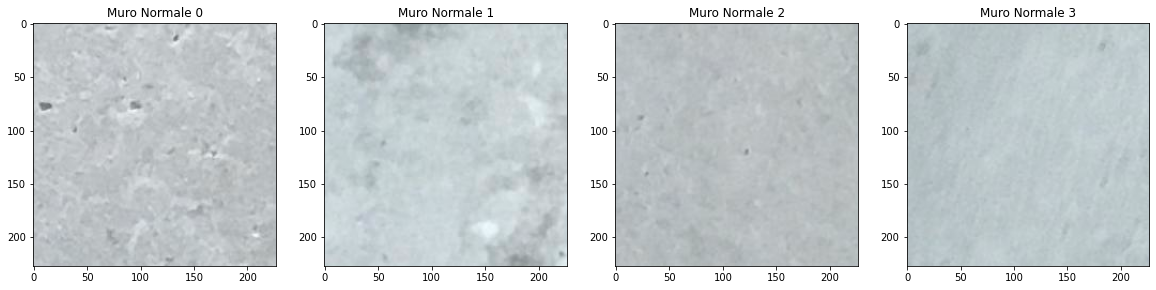

In [ ]:
show_data(train_data_normal, title = "Muro Normale", n_plots = plots, plot_height = plot_height, plot_width = plot_width)

### Immagini di Muri con delle crepe

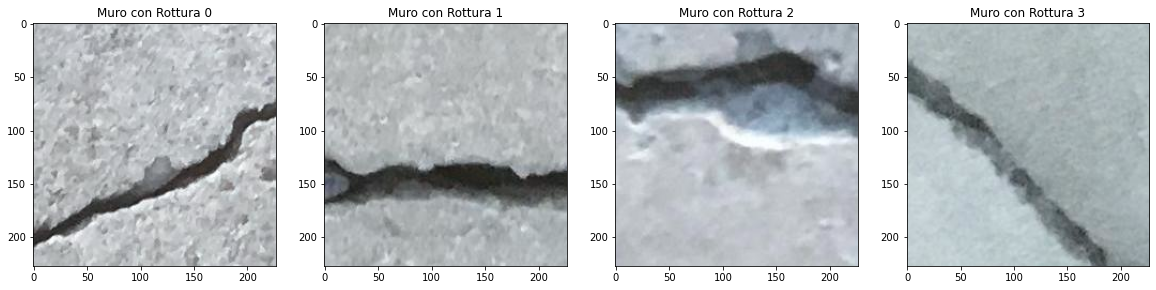

In [ ]:
show_data(train_data_cracks, title = "Muro con Rottura", n_plots = plots, plot_height = plot_height, plot_width = plot_width)

### Immagini di Muri con Spalling

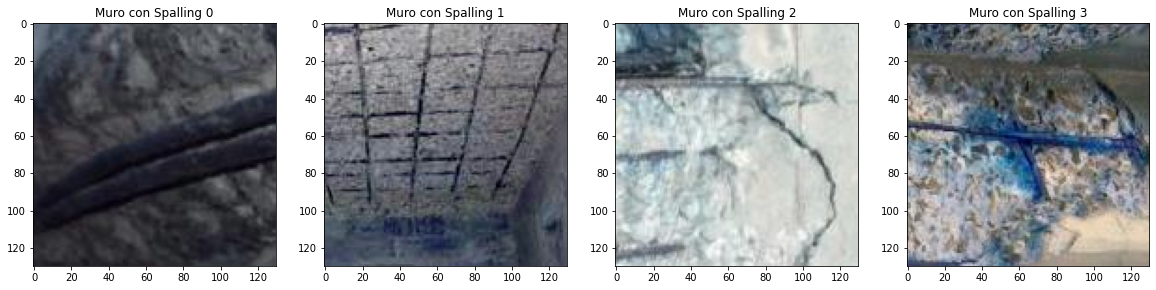

In [ ]:
show_data(train_data_spalling, title = "Muro con Spalling", n_plots = plots, plot_height = plot_height, plot_width = plot_width)

## 5. Dataset Transformations

### Definizione delle trasformazioni da applicare agli input

In [ ]:
# Mi prendo l'input size atteso della rete -> (width, height, channels)
input_image_size = JDUtils.getModelInputSize()
# Stats normalizzate del nostro dataset
dataset_normalized_stats = {'mean':mean, 'std':std}
# SE SI VUOLE USARE LE STATS DI IMAGENET SOVRASCRIVO LA SCELTA
if USE_IMAGENET_STATS:
  dataset_normalized_stats = imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}

train_tfms = JDUtils.get_training_tfms(dataset_normalized_stats)
valid_tfms = JDUtils.get_validation_tfms(dataset_normalized_stats)

print("Normalization stats usate -> Mean: " + str(dataset_normalized_stats['mean']) + " | STD: " + str(dataset_normalized_stats['std']))
print("Input Image dimension:", input_image_size)

Normalization stats usate -> Mean: [0.61536639 0.64865836 0.67007833] | STD: [0.15830689 0.15804278 0.15883725]
Input Image dimension: (227, 227, 3)


### Generazione dei Dataloader dei vari Subsets

In [ ]:
train_dl = JDUtils.get_training_dataloader(train_df, data_transformations = train_tfms, dl_bs = BS, dl_shuffle = True, num_dl_workers = DL_TRAINING_N_WORKERS)
valid_dl = JDUtils.get_training_dataloader(val_df, data_transformations = valid_tfms, dl_bs = BS, dl_shuffle = False, num_dl_workers = DL_VALIDATION_N_WORKERS)
test_dl = JDUtils.get_training_dataloader(test_df, data_transformations = valid_tfms, dl_bs = BS, dl_shuffle = False, num_dl_workers = DL_VALIDATION_N_WORKERS)

## 6. Training della Rete

### Metodo usato per il Fit della rete

In [ ]:
# Per semplicità di scrittura e lettura importo le funzioni di step
from JDModel import training_step as training_step
from JDModel import validation_step as validation_step

def fit(epochs, model, train_dl, valid_dl, opt, loss_fn, device=None):
    device = device if device else JDModel.get_device()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dl)*epochs)
    tloss = []
    vloss = []
    validation_accuracy = []
    best_model = model
    best_accuracy = 0.0
    lowest_val_loss = None
    
    # Creating progress bar
    data_table = master_bar(range(epochs))
    data_table.write(['epoch', 'train_loss', 'val_loss', 'val_accuracy(%)'],table=True)
    for epoch in data_table:    
        trn_loss, val_loss = 0.0, 0.0
        val_preds = np.zeros(len(valid_dl.dataset))
        val_targs = np.zeros((len(valid_dl.dataset), model.getOutputClasses()))
        
        # Training
        model.train()
        # For every batch 
        toprint = True
        for xb, yb in progress_bar(train_dl, parent = data_table):
            trn_loss += training_step(xb, yb, model, loss_fn, opt, device, scheduler)
        trn_loss /= data_table.child.total
        tloss.append(trn_loss)
        # -----

        # Validation
        model.eval()
        with torch.no_grad():
            for i,(xb, yb) in enumerate(progress_bar(valid_dl, parent = data_table)):
                loss, out = validation_step(xb, yb, model, loss_fn, device)
                val_loss += loss
                bs = xb.shape[0]
                val_targs[i*bs : i*bs+bs] = yb.cpu().numpy()
                #Prendo dei vari tensori quello con valore massimo, che mi indicherà la classe
                val_preds[i*bs : i*bs+bs] = torch.max(nn.Softmax(dim=1)(out), 1).indices.cpu().numpy()
        # -----

        #conto il numero di predizioni corrette
        correct = 0
        for target, index_pred in zip(val_targs, val_preds):
            if target[int(index_pred)] == 1:
                correct += 1
        
        val_accuracy = correct / len(val_preds) * 100
        validation_accuracy.append(val_accuracy)
        # -----

        # Prendo il modello con il minor valore di validation loss
        if lowest_val_loss == None or (lowest_val_loss != None and lowest_val_loss > val_loss):
            lowest_val_loss = val_loss
            best_model = copy.deepcopy(model)

        # Prendo il modello con la migliore accuracy
        #if val_accuracy > best_accuracy:
        #    best_accuracy = val_accuracy
        #    best_model = copy.deepcopy(model)
        # -----
        
        val_loss /= data_table.child.total
        vloss.append(val_loss)

        data_table.write([epoch, f'{trn_loss:.4f}', f'{val_loss:.4f}', f'{val_accuracy:.2f}'], table=True)
        
        # PERMETTE DI FAR SCENDERE LEARNING RATE E WD, IN PRATICA DICE CHE è FINITA L'EPOCA
        scheduler.step()
        
    return best_model, tloss, vloss, validation_accuracy

### Caricamento pesi della rete pre-allenata

In [ ]:
%%time
model, opt = JDModel.get_model(model_name=network_model_name, lr=LR, wd=WD, feature_extracting=feature_extract, n_classes=OC)

cont = 0
for p in model.backbone.parameters():
    cont+=1
print("Model backbone 'params': ", cont)
print("Dispositivo per training:", str(JDModel.get_device()))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3
----- ConcreteModel ----
New Classifier Stats: 
Input features 1° Linear:  1536
Input features 2° Linear:  768
Input features 3° Linear:  256
Output 3° Linear:  3
------------------------
Model backbone 'params':  340
Dispositivo per training: cuda:0
CPU times: user 3.37 s, sys: 1.58 s, total: 4.95 s
Wall time: 11.5 s


### Training effettivo della rete (Fine-tuning)

In [ ]:
%%time
model, train_loss, valid_loss, valid_accuracy = fit(TE, model, train_dl, valid_dl, opt, loss_fn)

epoch,train_loss,val_loss,val_accuracy(%)
0,0.1879,0.1351,92.97
1,0.1494,0.1325,92.37
2,0.1460,0.0746,96.57
3,0.1547,0.1242,93.88
4,0.1514,0.0620,96.23
5,3.5815,0.0709,96.39
6,0.0865,0.0846,95.89
7,0.0906,0.0564,97.25
8,0.0925,0.0729,96.57
9,0.0988,0.0620,96.87


CPU times: user 26min 45s, sys: 17min 20s, total: 44min 6s
Wall time: 45min 33s


## 7. Plot Risultati del Training

### Plot Training Loss

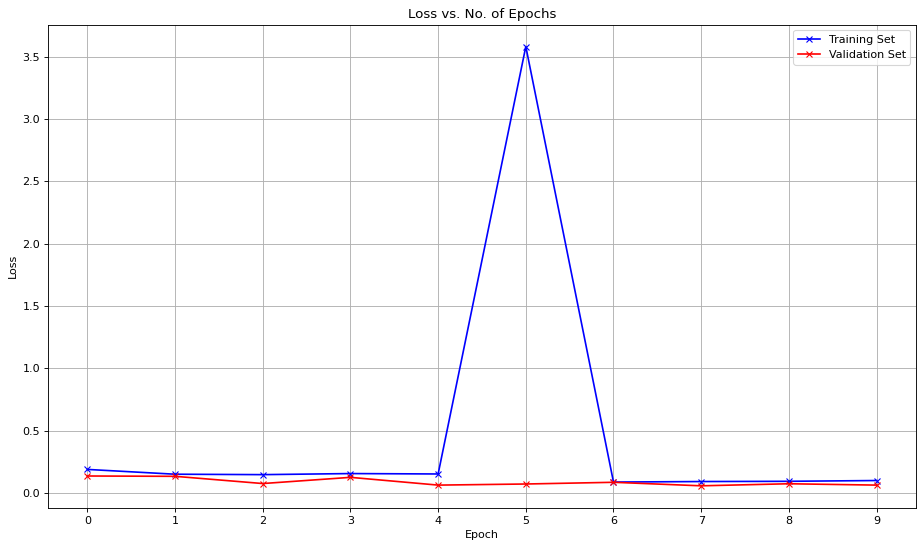

In [ ]:
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_loss, '-bx')
plt.plot(valid_loss, '-rx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.title('Loss vs. No. of Epochs');
plt.grid()

### Plot Training Accuracy

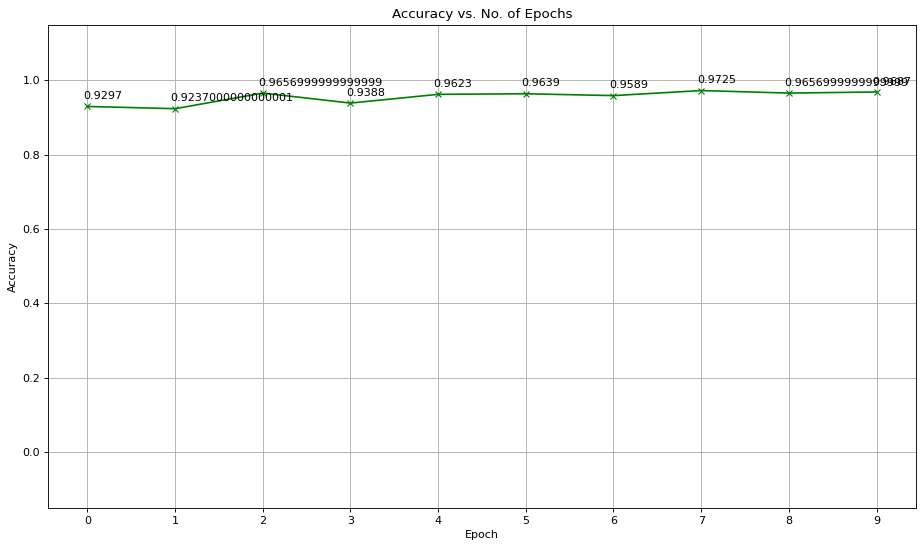

In [ ]:
# NORMALIZZO DA 0 A 1 E TOGLIO I NUMERI DOPO 2 POSIZIONI NELLA VIRGOLA
trains_accuracy_normalized = np.array(np.round(valid_accuracy, 2)) / 100

# FIGURA
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(trains_accuracy_normalized, '-gx')
plt.xlabel('Epoch')
plt.xticks(range(0, TE))
plt.ylabel('Accuracy')
plt.ylim(-0.15, 1.15)
plt.title('Accuracy vs. No. of Epochs');
plt.grid()

# NUMERINI SULLA GRIGLIA
for x,y in zip(trains_accuracy_normalized, range(0, len(trains_accuracy_normalized))):
    plt.annotate(str(x),xy=(y-0.05 ,x + 0.02))

## 8. Test Della rete Sul Test Set

### Esecuzione della rete sul test-set

In [ ]:
# Per semplicità di scrittura e lettura importo la funzione di step di test
from JDModel import test_step as test_step

# Preparo l'array contenente le predizioni
test_preds = np.zeros(len(test_dl.dataset))
# Imposto la rete in modalità evaluate
model.eval()
with torch.no_grad():
  device = JDModel.get_device()
  for i, (xb, yb) in enumerate(progress_bar(test_dl)):
    out, bs = test_step(xb, model, device)
    test_preds[i*bs : i*bs+bs] = out
# Trasformo il tensore risultato, prendendo il valore maggiore che mi indica la classe
preds_correct = 0
for target, index_pred in zip(test_df[c_label], test_preds):
    if target[int(index_pred)] == 1:
        preds_correct += 1
print("Accuracy: ", f'{preds_correct / len(test_preds) * 100:.2f}' + "%")

Accuracy:  78.57%


### Matrice di confusione delle predizioni sul test set

In [ ]:
# Trasformo gli indici in label del test set
y_true = []
for element in test_df[:][c_label]:
  if element[0] == 1:
    y_true.append(0)
  elif element[1] == 1:
    y_true.append(1)
  else:
    y_true.append(2)

# Stampo la matrice di confusione di sklearn
print(confusion_matrix(np.array(y_true), test_preds, labels=[0, 1, 2]))

[[192   9  12]
 [ 43 124  11]
 [ 49   8 168]]


### Plot di alcune predizioni

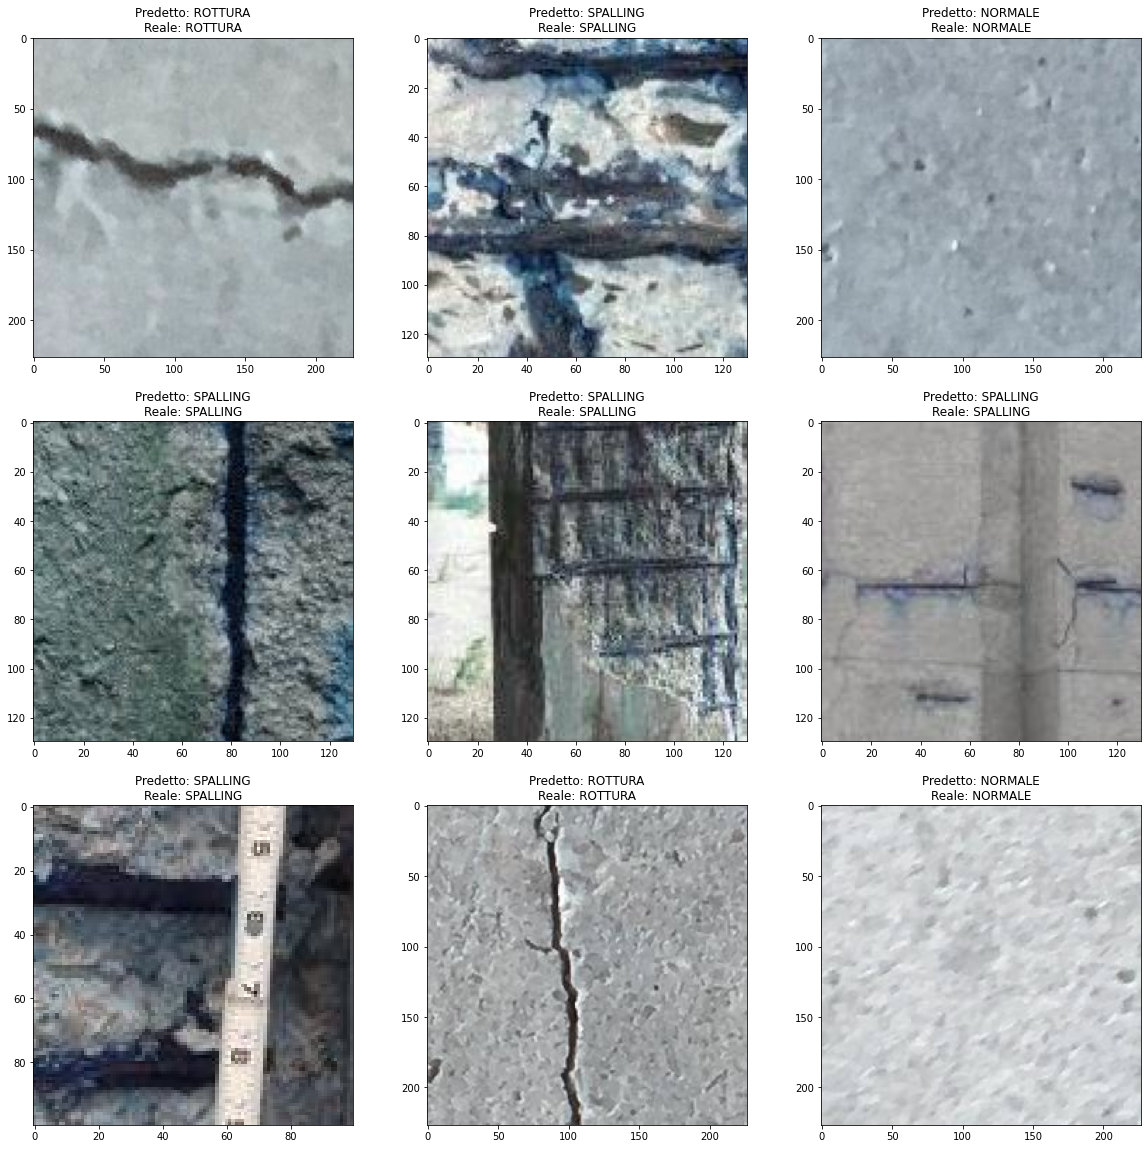

In [ ]:
# Creo plot ed imposto le dimensioni
fig,a =  plt.subplots(3, 3)
fig.set_figheight(plot_height)
fig.set_figwidth(plot_width)

# Carico le immagini da plottare
cont = 0
i = j = 0
for uao in range (0, len(test_preds)):
  if cont >= 100 and cont < 109:
    predicted_class = int(test_preds[cont])
    real_class = np.argmax(test_df.iloc[cont][c_label])
    title = None
    a[i][j].imshow(cv.imread(str(test_df.iloc[cont][c_filepath])))

    # Definisco il titolo della immagine in base alla classificazione della rete
    if predicted_class == 0:
      title = "Predetto: NORMALE"
    else:
      if predicted_class == 1:
        title = "Predetto: ROTTURA"
      else:
        title = "Predetto: SPALLING"

    if real_class == 0:
      title = title + "\nReale: NORMALE"
    else:
      if real_class == 1:
        title = title + "\nReale: ROTTURA"
      else:
        title = title + "\nReale: SPALLING"
    a[i][j].set_title(title)
    j += 1
    if j == 3:
      j = 0
      i += 1
  cont += 1

## 9. Salvataggio del Modello

### Informazioni del modello e dell'optimizer

In [ ]:
# DECOMMENTARE I 2 CICLI FOR E LE CORRISPETTIVE PRINT PER MOSTRARE LE INFORMAZIONI

# Print informazioni del modello
print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\n\n##################################################  ##################################################")
print("##################################################  ##################################################\n\n")

# Print informazioni dell'ottimizzatore
print("Optimizer's state_dict:")
#for var_name in opt.state_dict():
#    print(var_name, "\t", opt.state_dict()[var_name])

Model's state_dict:


##################################################  ##################################################
##################################################  ##################################################


Optimizer's state_dict:


### Salvataggio del modello

In [ ]:
# Salvataggio
torch.save(model.state_dict(), MODEL_SAVE_PATH)
# Mi scollego dal drive
if _COLAB_IN_USE:
  drive.flush_and_unmount()